In [ ]:
!pip install torch_geometric

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import networkx as nx
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from torch_geometric.utils.convert import from_networkx
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

In [ ]:
%cd /content/drive/MyDrive/emotion_data_preprocessed
from model1 import DirectionalGraphNeuralNetwork
%cd /content

/content/drive/MyDrive/emotion_data_preprocessed
/content


In [ ]:
# Đầu vào và đầu ra của mô hình
num_node_features = 1  # Thay thế bằng số đặc trưng của mỗi đỉnh
num_edge_features = 1  # Thay thế bằng số đặc trưng của mỗi cạnh
num_classes = 7  # Thay thế bằng số lớp đầu ra tương ứng với nhiệm vụ của bạn

# Tạo mô hình DGNN
dgnn_model = DirectionalGraphNeuralNetwork(
    num_node_features, num_edge_features, num_classes)
print(dgnn_model)

DirectionalGraphNeuralNetwork(
  (block1): DirectionalGraphNeuralNetworkBlock(
    (graph_conv): DirectionalGraphConvolution(
      (conv): GCNConv(1, 64)
    )
  )
  (block2): DirectionalGraphNeuralNetworkBlock(
    (graph_conv): DirectionalGraphConvolution(
      (conv): GCNConv(64, 64)
    )
  )
  (block3): DirectionalGraphNeuralNetworkBlock(
    (graph_conv): DirectionalGraphConvolution(
      (conv): GCNConv(64, 128)
    )
  )
  (block4): DirectionalGraphNeuralNetworkBlock(
    (graph_conv): DirectionalGraphConvolution(
      (conv): GCNConv(128, 128)
    )
  )
  (block5): DirectionalGraphNeuralNetworkBlock(
    (graph_conv): DirectionalGraphConvolution(
      (conv): GCNConv(128, 256)
    )
  )
  (block6): DirectionalGraphNeuralNetworkBlock(
    (graph_conv): DirectionalGraphConvolution(
      (conv): GCNConv(256, 256)
    )
  )
  (block7): DirectionalGraphNeuralNetworkBlock(
    (graph_conv): DirectionalGraphConvolution(
      (conv): GCNConv(256, 512)
    )
  )
  (block8): Dire

In [ ]:
with open('/content/drive/MyDrive/emotion_data_preprocessed/data_dict.pkl', 'rb') as file:
    loaded_data_dict = pickle.load(file)

print(len(loaded_data_dict['train']['images']))

9520


In [ ]:
def compute_node_feature(graph_list, set_name):
    node_features_list = []
    for i, graph in enumerate(tqdm(graph_list, desc=f"Computing node features for {set_name} set", unit="graph")):
        # Assuming you want to use the 'nodes' attribute for node features
        node_feature = torch.tensor(graph.nodes, dtype=torch.float32).view(1, -1).t()
        node_features_list.append(node_feature)
    return node_features_list

In [ ]:
# Compute node features for the training set
node_features_train = compute_node_feature(loaded_data_dict['train']['images'], 'training')

# Compute node features for the validation set
node_features_valid = compute_node_feature(loaded_data_dict['valid']['images'], 'validation')

# Compute node features for the test set
node_features_test = compute_node_feature(loaded_data_dict['test']['images'], 'testing')

Computing node features for testing set: 100%|██████████| 1386/1386 [00:00<00:00, 52083.08graph/s]


In [ ]:
def convert_and_print_progress(graph_list, set_name):
    pyg_graphs_list = []
    for i, graph in enumerate(tqdm(graph_list, desc=f"Converting {set_name} set")):
        pyg_graph = from_networkx(graph)
        pyg_graphs_list.append(pyg_graph)
    return pyg_graphs_list


In [ ]:
# Convert all graphs to PyTorch Geometric format for the training set
pyg_graphs_train = convert_and_print_progress(loaded_data_dict['train']['images'], 'training')

# Convert all graphs to PyTorch Geometric format for the validation set
pyg_graphs_valid = convert_and_print_progress(loaded_data_dict['valid']['images'], 'validation')

# Convert all graphs to PyTorch Geometric format for the test set
pyg_graphs_test = convert_and_print_progress(loaded_data_dict['test']['images'], 'testing')

Converting testing set: 100%|██████████| 1386/1386 [00:18<00:00, 75.48it/s]


In [ ]:
def extract_edge_info_with_progress(graph_list, set_name):
    all_edge_index = []
    all_edge_weight = []

    for i, graph in enumerate(tqdm(graph_list, desc=f"Extracting edge information for {set_name}", unit="graph")):
        # Assuming each graph is a networkx graph
        edge_index = torch.tensor(list(graph.edges)).t().contiguous()
        edge_weight = torch.tensor([graph[u][v]['weight'] for u, v in graph.edges], dtype=torch.float32)

        all_edge_index.append(edge_index)
        all_edge_weight.append(edge_weight)

    return all_edge_index, all_edge_weight

In [ ]:
# Example usage
train_edge_index, train_edge_weight = extract_edge_info_with_progress(loaded_data_dict['train']['images'], 'training')
valid_edge_index, valid_edge_weight = extract_edge_info_with_progress(loaded_data_dict['valid']['images'], 'validation')
test_edge_index, test_edge_weight = extract_edge_info_with_progress(loaded_data_dict['test']['images'], 'testing')

Extracting edge information for testing: 100%|██████████| 1386/1386 [00:01<00:00, 1164.03graph/s]


In [ ]:
def convert_labels_to_one_hot(label_list, num_classes, set_name):
    tensor_list = []
    for i, label in enumerate(tqdm(label_list, desc=f"Converting labels to one-hot tensors for {set_name}", unit="label")):
        # Assuming label is a single number representing the class index
        one_hot_label = [1 if j == label else 0 for j in range(num_classes)]
        tensor = torch.tensor(one_hot_label, dtype=torch.float32).view(1, -1)
        tensor_list.append(tensor)
    return tensor_list

In [ ]:
num_classes = 7  # Replace with the actual number of classes
labels_train_tensor = convert_labels_to_one_hot(loaded_data_dict['train']['labels'], num_classes, 'training')
labels_test_tensor = convert_labels_to_one_hot(loaded_data_dict['test']['labels'], num_classes, 'testing')
labels_valid_tensor = convert_labels_to_one_hot(loaded_data_dict['valid']['labels'], num_classes, 'validation')

Converting labels to one-hot tensors for training: 100%|██████████| 9520/9520 [00:00<00:00, 95345.12label/s]
Converting labels to one-hot tensors for testing: 100%|██████████| 1386/1386 [00:00<00:00, 54970.60label/s]
Converting labels to one-hot tensors for validation: 100%|██████████| 2688/2688 [00:00<00:00, 97266.77label/s]


In [ ]:
print(labels_train_tensor[532])
print(loaded_data_dict['train']['labels'][532])

tensor([[0., 0., 1., 0., 0., 0., 0.]])
2


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dgnn_model.parameters(), lr=0.005)

In [ ]:
batch_size = 64 # Define your batch size

# Assuming you have DataLoader for batching
train_dataset = [Data(x=node_features_train[i], edge_index=train_edge_index[i], weight=train_edge_weight[i], y=labels_train_tensor[i])
                 for i in range(len(pyg_graphs_train))]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Assuming you have DataLoader for batching
valid_dataset = [Data(x=node_features_valid[i], edge_index=valid_edge_index[i], weight=valid_edge_weight[i], y=labels_valid_tensor[i])
                 for i in range(len(pyg_graphs_valid))]

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dgnn_model = dgnn_model.to(device)

In [ ]:
num_epochs = 43

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # Training
    dgnn_model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for data in train_loader:
        data = data.to(device)  # Chuyển dữ liệu vào GPU
        optimizer.zero_grad()
        output = dgnn_model(data.x, data.edge_index, data.weight, batch=data.batch)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Tính accuracy trong quá trình huấn luyện
        _, predicted_train = torch.max(output, 1)
        correct_train += (predicted_train == data.y.argmax(1)).sum().item()
        total_train += data.y.size(0)

    average_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation
    dgnn_model.eval()  # Set the model to evaluation mode
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for valid_data in valid_loader:
            valid_data = valid_data.to(device)
            valid_output = dgnn_model(valid_data.x, valid_data.edge_index, valid_data.weight, batch=valid_data.batch)
            valid_loss = criterion(valid_output, valid_data.y)
            total_valid_loss += valid_loss.item()

            # Tính accuracy trên tập validation
            _, predicted_valid = torch.max(valid_output, 1)
            correct_valid += (predicted_valid == valid_data.y.argmax(1)).sum().item()
            total_valid += valid_data.y.size(0)

    average_valid_loss = total_valid_loss / len(valid_loader)
    valid_accuracy = correct_valid / total_valid
    train_losses.append(average_loss)
    valid_losses.append(average_valid_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {average_valid_loss}, Valid Accuracy: {valid_accuracy}")


Epoch 1/43, Train Loss: 1.7998594797697642, Train Accuracy: 0.2976890756302521, Valid Loss: 1.7228665493783497, Valid Accuracy: 0.33705357142857145
Epoch 2/43, Train Loss: 1.478978674683795, Train Accuracy: 0.466281512605042, Valid Loss: 1.3220015026274181, Valid Accuracy: 0.5022321428571429
Epoch 3/43, Train Loss: 1.225621771092383, Train Accuracy: 0.567436974789916, Valid Loss: 1.1047146930581047, Valid Accuracy: 0.6011904761904762
Epoch 4/43, Train Loss: 1.0701802628952384, Train Accuracy: 0.6176470588235294, Valid Loss: 0.8775476160503569, Valid Accuracy: 0.65625
Epoch 5/43, Train Loss: 0.9606980933439011, Train Accuracy: 0.6422268907563026, Valid Loss: 1.010017217624755, Valid Accuracy: 0.6063988095238095
Epoch 6/43, Train Loss: 0.8426354013433393, Train Accuracy: 0.6747899159663866, Valid Loss: 0.8259470008668446, Valid Accuracy: 0.6729910714285714
Epoch 7/43, Train Loss: 0.802877060919, Train Accuracy: 0.6800420168067227, Valid Loss: 0.7555326549779802, Valid Accuracy: 0.71875
E

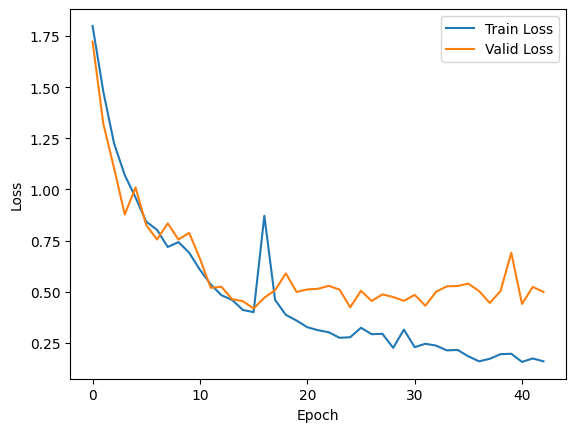

In [ ]:
import matplotlib.pyplot as plt
# Vẽ biểu đồ
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# After training
torch.save(dgnn_model.state_dict(), '/content/drive/MyDrive/emotion_data_preprocessed/save_models/model5.pth')

In [ ]:
# Load the model architecture
loaded_model = DirectionalGraphNeuralNetwork(num_node_features, num_edge_features, num_classes)

# Load the state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/emotion_data_preprocessed/save_models/model5.pth'))

# Put the model on the device (CPU or GPU)
loaded_model = loaded_model.to(device)

# Set the model in evaluation mode
loaded_model.eval()

DirectionalGraphNeuralNetwork(
  (block1): DirectionalGraphNeuralNetworkBlock(
    (graph_conv): DirectionalGraphConvolution(
      (conv): GCNConv(1, 64)
    )
  )
  (block2): DirectionalGraphNeuralNetworkBlock(
    (graph_conv): DirectionalGraphConvolution(
      (conv): GCNConv(64, 64)
    )
  )
  (block3): DirectionalGraphNeuralNetworkBlock(
    (graph_conv): DirectionalGraphConvolution(
      (conv): GCNConv(64, 128)
    )
  )
  (block4): DirectionalGraphNeuralNetworkBlock(
    (graph_conv): DirectionalGraphConvolution(
      (conv): GCNConv(128, 128)
    )
  )
  (block5): DirectionalGraphNeuralNetworkBlock(
    (graph_conv): DirectionalGraphConvolution(
      (conv): GCNConv(128, 256)
    )
  )
  (block6): DirectionalGraphNeuralNetworkBlock(
    (graph_conv): DirectionalGraphConvolution(
      (conv): GCNConv(256, 256)
    )
  )
  (block7): DirectionalGraphNeuralNetworkBlock(
    (graph_conv): DirectionalGraphConvolution(
      (conv): GCNConv(256, 512)
    )
  )
  (block8): Dire

In [ ]:
# Assuming you have DataLoader for batching
test_dataset = [Data(x=node_features_test[i], edge_index=test_edge_index[i], weight=test_edge_weight[i], y=labels_test_tensor[i])
                 for i in range(len(pyg_graphs_test))]

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Dự đoán trên tập dữ liệu kiểm thử
all_predictions = []
all_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_data = test_data.to(device)
        output = loaded_model(test_data.x, test_data.edge_index, test_data.weight, batch=test_data.batch)
        predictions = torch.argmax(output, dim=1).cpu().numpy()
        labels = test_data.y.cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels)

In [ ]:
# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# If all_labels is one-hot encoded, convert to single-class labels
if len(all_labels.shape) > 1:
    all_labels = np.argmax(all_labels, axis=1)

# Now you can compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

In [ ]:
# Tính confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

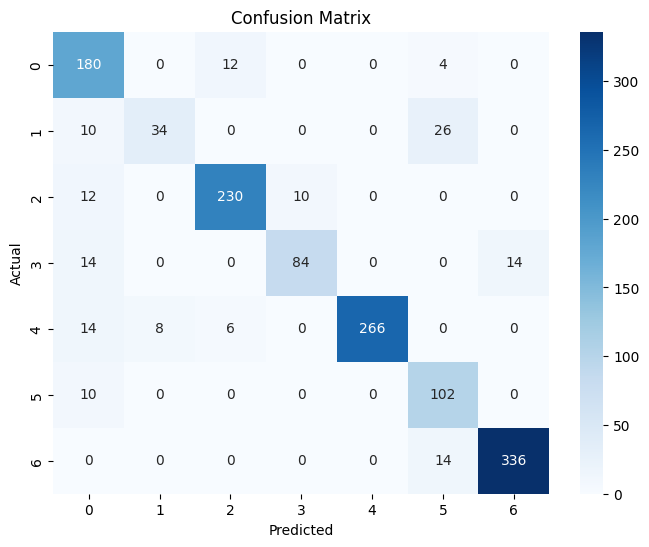

In [ ]:
import matplotlib.pyplot as plt
# Vẽ confusion matrix bằng heatmap
class_names = [str(i) for i in range(num_classes)]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(all_labels, all_predictions, average='weighted')
print(f'Precision: {precision}')

# Calculate recall
recall = recall_score(all_labels, all_predictions, average='weighted')
print(f'Recall: {recall}')

# Calculate F1 score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f'F1 Score: {f1}')

Accuracy: 0.8888888888888888
Precision: 0.8987792394022122
Recall: 0.8888888888888888
F1 Score: 0.8884363692247096
